### SELF-SUPERVISED DENOISING: PART TWO 
# Random Noise Suppression with Blind-Spot Networks: Field Data Application
### _Authors: [Claire Birnie](https://cebirnie92.github.io/)_, _KAUST_

The true test of any proposed method is in its successful application to field data.

This is the second tutorial in our self-supervised seismic denoising tutorial series. Here we advance on the concepts introduced in the first tutorial to apply the blind-spot procedure to field data. The field data comprises of a post-stack seismic slice, originally obtained from the [Madagascar repository](https://github.com/ahay/src) and has been regularly used for benchmarking random noise suppression procedures.

The tutorial notebooks were originally designed to supplement the course slides. However, it should still be easy to follow provided you have read the reference paper and understood the key concepts.

## Tutorial Objectives

On completion of this tutorial, you will have 
- loaded a post-stack seismic image 
- use helper functions to cut the image into training patches
- utilised your previously written functions for selecting and corrupting active pixels
- use helper functions to load a UNet
- import your previously written functions the train and evaluate functions
- write the training procedure
- apply the trained network to the original seismic image

## Prior Requisites:
Complete tutorial 1 and ensure you understand the corruption, training and evaluate functions that were written. These functions have been copied into ssdn_functions.py. Writing the code is a great way to ensure you fully understand the methodology and there is no one 'correct' way to write the functions, therefore if you chose to write your own in tutorial 1 then copy-paste your functions into ssdn_functions.py.

## Reference Paper:
Birnie, C., Ravasi, M., Liu, S. and Alkhalifah, T., 2021. The potential of self-supervised networks for random noise suppression in seismic data. Artificial Intelligence in Geosciences, 2, pp.47-59.

[[Paper Link]](https://doi.org/10.1016/j.aiig.2021.11.001)

## Key Concepts Recap
#### _N2V: Random Noise Suppression_
In this series of tutorials, we implement the Noise2Void methodology of [Krull et al., [2019]](https://openaccess.thecvf.com/content_CVPR_2019/papers/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.pdf) for self-supervised denoising using blind-spot networks. This approach involves a pre-processing step that identifies a set of 'active' pixels, substituting their original noisy values with those of neighboring pixels. This processed data becomes the input to the neural network with the original noisy image being the network's target. However, unlike in most NN applications, the loss is not computed across the full predicted image, but only at the active pixel locations. Assuming the noise is i.i.d., the network is unable to predict the noise component of the active pixels' original values, thereby learning to reconstruct only the signal component. This results in a denoised image.




***

In [1]:
# Import necessary basic packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm 
import os

# Import necessary torch packages
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

# Import our pre-made functions which will keep the notebook concise
# These functions are independent to the blindspot application however important for the data handling and 
# network creation/initialisation
from unet import UNet
import tutorial_utils as tu
import plotting_utils as pu


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Some general plotting parameters so we don't need to keep adding them later on
cmap='RdBu'
vmin = -0.25
vmax = 0.25

# For reproducibility purposes we set random, numpy and torch seeds
tu.set_seed(42) 

# Set paths
data_dir = './data'
networks_dir = './trained_networks'

***

# Step One - Data loading

In this example we are going to use a field post-stack depth migrated image, originally obtained from the Madagascar repo, that is commonly used for benchmarking random noise suppression procedure. The data is available  from [this One Drive](https://drive.google.com/drive/folders/1AovokXsyo6VYxfzLZ2gpvVHLadh5wuN1?usp=sharing).

(696, 300)


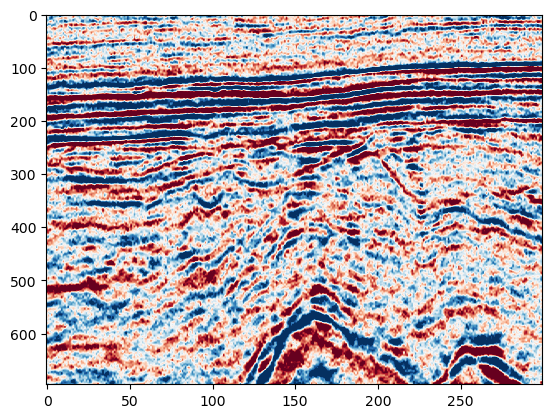

In [3]:
field_data = np.load(os.path.join(data_dir,"FieldExample_RandomNoise.npy"))[:696,:300]
print(field_data.shape)
# Plot to see the noise free data
plt.imshow(field_data, cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')

### Patch data

At the moment we have a single image that we wish to denoise however to train the network we need to give it multiple data examples. Therefore, following common computer vision methodology, we will select random patches from the data for the networks training. 

Our patch implementation involves first regularly extracting patches from the image and then shuffling the patches such that they are in a random order. Later at the training stage these patches will be split into train and test dataset.

In [4]:
# Regularly extract patches from the noisy data
noisy_patches = tu.regular_patching_2D(field_data, 
                                       patchsize=[32, 32], # dimensions of extracted patch
                                       step=[4,6], # step to be taken in y,x for the extraction procedure
                                       )

# Randomise patch order
shuffler = np.random.permutation(len(noisy_patches))
noisy_patches = noisy_patches[shuffler] 

Extracting 7470 patches


#### Visualise the training patches

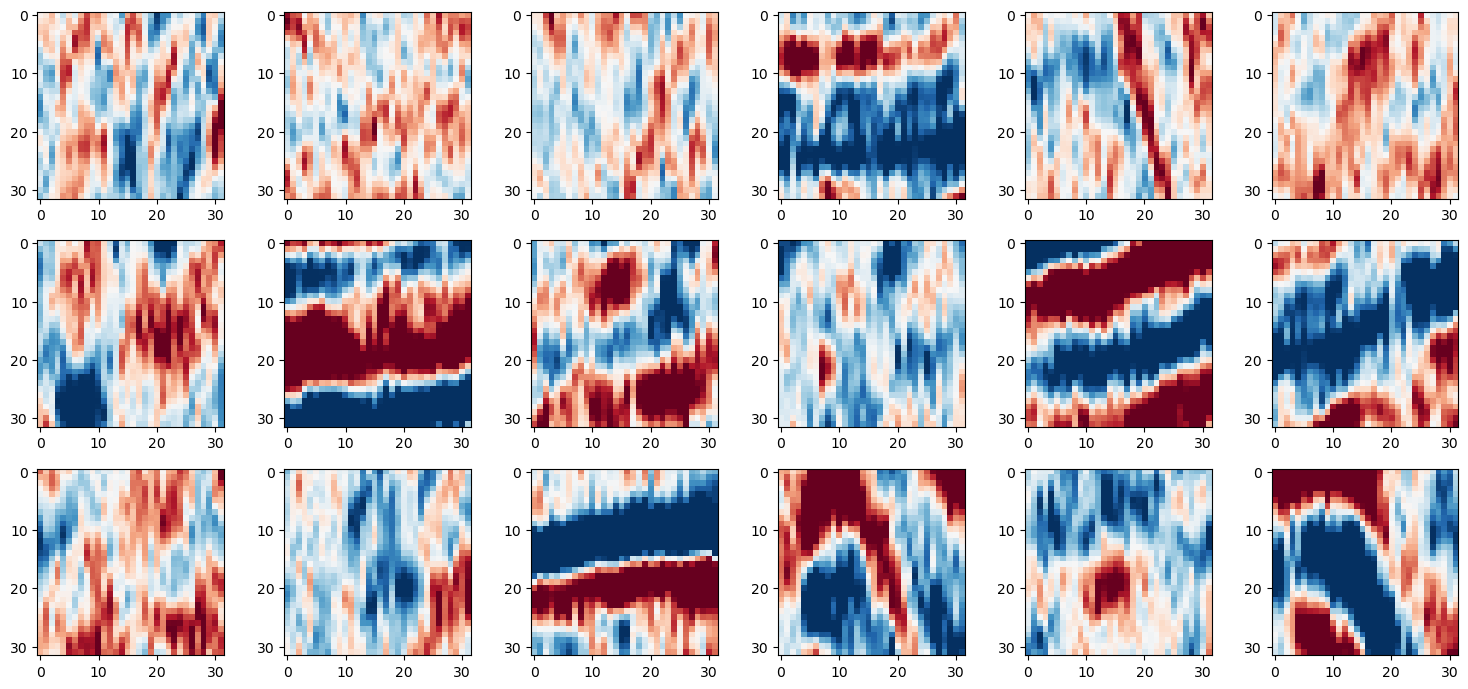

In [5]:
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

***

# Step Two - Blindspot corruption of training data

Now we have made our noisy data into patches such that we have an adequate number to train the network, we now need to pre-process these noisy patches prior to being input into the network. 

Our implementation of the preprocessing involves:

    - selecting the active pixels 
    - selecting the neighbourhood pixel for each active pixel, which it will take the value of
    - replacing each active pixels' value with its neighbourhood pixels' value
    - creating a active pixel 'mask' which shows the location of the active pixels on the patch
    
The first three steps are important for the pre-processing of the noisy patches, whilst the fourth step is required for identifying the locations on which to compute the loss function during training.

### Import our corruption function from tutorial 1

In [6]:
from ssdn_functions import blind_spot_corruption

#### Check the corruption function still works as expected

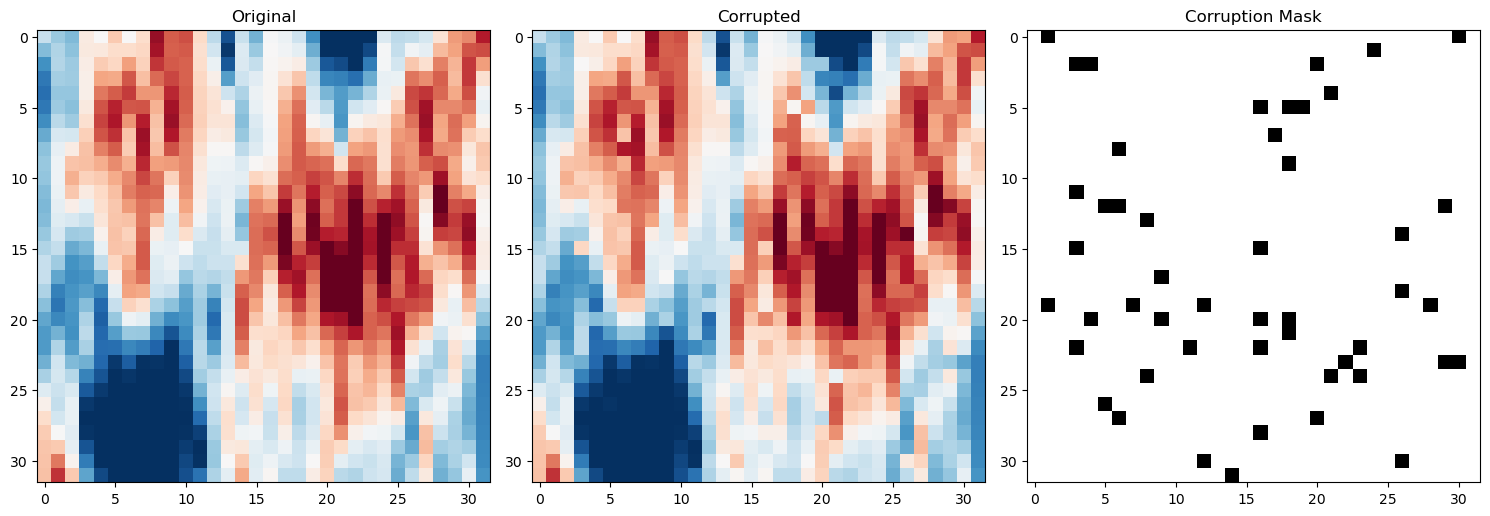

In [7]:
# Input the values of your choice into your pre-processing function
crpt_patch, mask = blind_spot_corruption(noisy_patches[6], 
                                       num_activepixels=50, 
                                       neighbourhood_radius=5, 
                                      )

# Use the pre-made plotting function to visualise the corruption
fig,axs = pu.plot_corruption(noisy_patches[6], crpt_patch, mask)

#### TO DO: SELECT THE NUMBER OF ACTIVE PIXELS (AS PERCENTAGE)
For seismic field data, the i.i.d. assumption for blind-spot networks is often void, due to weak coherency in seismic random noise. [Birnie et al., 2021](https://doi.org/10.1016/j.aiig.2021.11.001) showed how that assumption can be 'loosened' when working with seismic field data by increasing the number of active pixels and severely decreasing the number of training epochs.

For this tutorial, first try running the procedure with the original N2V params of 2% active pixels and 200 epochs, then repeat with 33% active pixels and only 25 epochs. 

In [8]:
# Choose the percent of active pixels per patch
perc_active = 33
num_activepixels = tu.num_active_pixs(noisy_patches[0].shape, percent_active=perc_active)

# Choose the neighbourhood_radius to be searched for the neighbouring pixel
neighbourhood_radius = 15

Number of active pixels selected: 
 33.00 percent equals 337 pixels


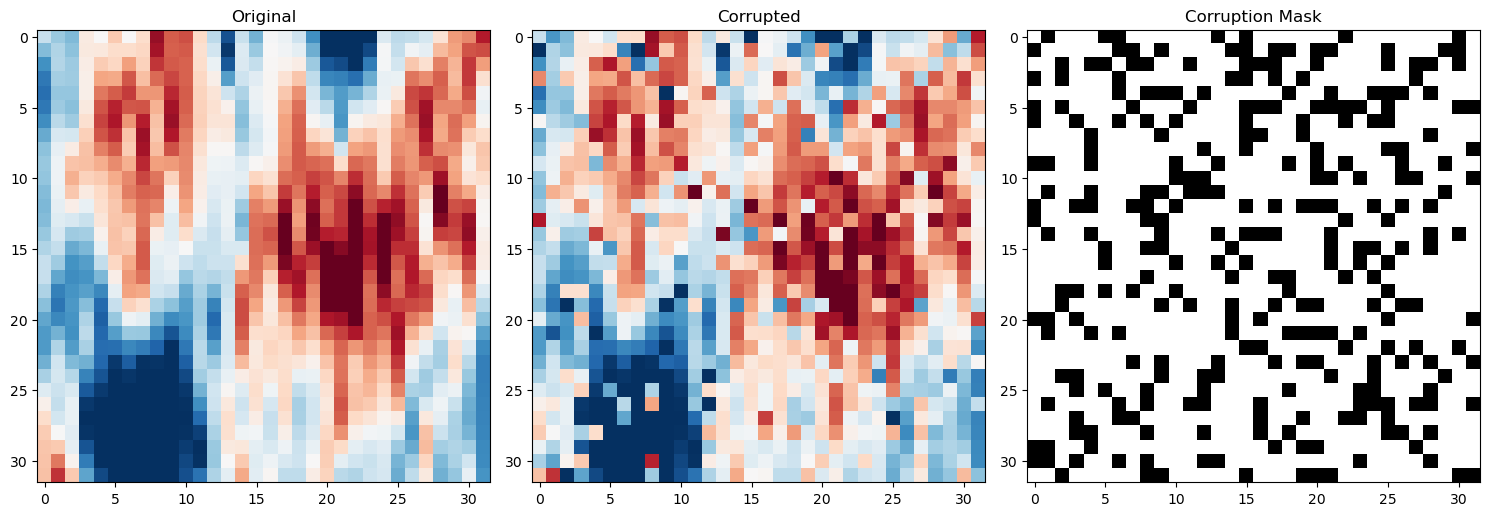

In [9]:
# Input the values of your choice into your pre-processing function
crpt_patch, mask = blind_spot_corruption(noisy_patches[6], 
                                         num_activepixels=num_activepixels, 
                                         neighbourhood_radius=neighbourhood_radius, 
                                         )

# Visulise the coverage of active pixels within a patch
fig,axs = pu.plot_corruption(noisy_patches[6], crpt_patch, mask)

***

# Step three - Set up network

In the N2V application of Krull et al., 2018, the network is not specially tailored to the blindspot task. As such, in theory any network could be used that goes from one input image to another of the same size.

In this example, like in Krull et al., 2018 and Birnie et al., 2021's seismic application, we will use a standard UNet architecture. As the architecture is independent to the blind-spot denoising procedure presented, it will be created via functions as opposed to being wrote within the notebook. 

In [10]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
elif torch.backends.mps.is_available(): 
    print("M1 installed! Running on M1!")
    device = torch.device("mps")
else:
    print("No GPU available!")

M1 installed! Running on M1!


#### Build the network

In [11]:
# Build UNet from pre-made function
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)
# Initialise UNet's weights from pre-made function
network = network.apply(tu.weights_init) 

#### Select the networks training parameters

In [12]:
lr = 0.0001  # Learning rate
criterion = nn.MSELoss()  # Loss function
optim = torch.optim.Adam(network.parameters(), lr=lr)  # Optimiser

***

# Step four - Network Training

Now we have successfully built our network and prepared our data - by patching it to get adequate training samples and creating the input data by selecting and corrupting the active pixels. We are now ready to train the network.

Remember, the network training is slightly different to standard image processing tasks in that we will only be computing the loss on the active pixels.

#### TO DO: DEFINE TRAINING PARAMETERS

In [13]:
# Choose the number of epochs
n_epochs = 25

# Choose number of training and validation samples
n_training = 2048
n_test = 512

# Choose the batch size for the networks training
batch_size = 128

In [14]:
# Initialise arrays to keep track of train and validation metrics
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
test_loss_history = np.zeros(n_epochs)
test_accuracy_history = np.zeros(n_epochs)

# Create torch generator with fixed seed for reproducibility, to be used with the data loaders
g = torch.Generator()
g.manual_seed(0)

## Import the training and evaluation functions that you wrote in tutorial 1
If you did not complete tutorial one, go back and copy paste the skeleton code of the train and evaluate functions and complete them. You can either directly copy-paste into a new cell that you create below, or you can copy-paste them into the ssdn_functions.py file and import them - as is recommended for those who have completed tutorial one.

In [15]:
from ssdn_functions import n2v_train, n2v_evaluate

#### TO DO: COMPLETE TRAINING LOOP BY CORRUPTION AND NETWORK FUNCTIONS

In [16]:
# TRAINING
for ep in range(n_epochs):  
        
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        
        # TO DO: USE ACTIVE PIXEL FUNCTION TO COMPUTE INPUT DATA AND MASKS
        # Hint: One line of code
        corrupted_patches[pi], masks[pi] = blind_spot_corruption(noisy_patches[pi], 
                                                               num_activepixels=num_activepixels, 
                                                               neighbourhood_radius=neighbourhood_radius, 
                                                              )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # MAKE DATA LOADERS - using pre-made function 
    train_loader, test_loader = tu.make_data_loader(noisy_patches, 
                                                 corrupted_patches, 
                                                 masks, 
                                                 n_training,
                                                 n_test,
                                                 batch_size = batch_size,
                                                 torch_generator=g
                                                )

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # TRAIN
    # TO DO: Incorporate n2v_train function
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)
    # Keeping track of training metrics
    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # EVALUATE (AKA VALIDATION)
    # TO DO: Incorporate n2v_evaluate function
    test_loss, test_accuracy = n2v_evaluate(network, 
                                            criterion,
                                            optim,
                                            test_loader, 
                                            device,)
    # Keeping track of validation metrics
    test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ 
    # PRINTING TRAINING PROGRESS
    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, 
    Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')


torch.save(network, os.path.join(networks_dir,'Tutorial2_FieldBlindspot.net'))

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.17it/s]


Epoch 0, 
    Training Loss 0.0060,     Training Accuracy 0.1434, 
    Test Loss 0.0033,     Test Accuracy 0.1061 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.34it/s]


Epoch 1, 
    Training Loss 0.0025,     Training Accuracy 0.0913, 
    Test Loss 0.0019,     Test Accuracy 0.0816 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.09it/s]


Epoch 2, 
    Training Loss 0.0017,     Training Accuracy 0.0791, 
    Test Loss 0.0015,     Test Accuracy 0.0743 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.62it/s]


Epoch 3, 
    Training Loss 0.0015,     Training Accuracy 0.0732, 
    Test Loss 0.0013,     Test Accuracy 0.0696 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.81it/s]


Epoch 4, 
    Training Loss 0.0013,     Training Accuracy 0.0692, 
    Test Loss 0.0012,     Test Accuracy 0.0667 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.67it/s]


Epoch 5, 
    Training Loss 0.0012,     Training Accuracy 0.0663, 
    Test Loss 0.0012,     Test Accuracy 0.0644 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.61it/s]


Epoch 6, 
    Training Loss 0.0012,     Training Accuracy 0.0644, 
    Test Loss 0.0011,     Test Accuracy 0.0632 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.38it/s]


Epoch 7, 
    Training Loss 0.0011,     Training Accuracy 0.0635, 
    Test Loss 0.0011,     Test Accuracy 0.0624 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.05it/s]


Epoch 8, 
    Training Loss 0.0011,     Training Accuracy 0.0629, 
    Test Loss 0.0010,     Test Accuracy 0.0612 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.92it/s]


Epoch 9, 
    Training Loss 0.0011,     Training Accuracy 0.0618, 
    Test Loss 0.0011,     Test Accuracy 0.0612 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 14.74it/s]


Epoch 10, 
    Training Loss 0.0011,     Training Accuracy 0.0615, 
    Test Loss 0.0010,     Test Accuracy 0.0603 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.28it/s]


Epoch 11, 
    Training Loss 0.0010,     Training Accuracy 0.0604, 
    Test Loss 0.0010,     Test Accuracy 0.0595 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 12.88it/s]


Epoch 12, 
    Training Loss 0.0010,     Training Accuracy 0.0601, 
    Test Loss 0.0010,     Test Accuracy 0.0594 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 10.50it/s]


Epoch 13, 
    Training Loss 0.0010,     Training Accuracy 0.0596, 
    Test Loss 0.0010,     Test Accuracy 0.0592 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.40it/s]


Epoch 14, 
    Training Loss 0.0010,     Training Accuracy 0.0593, 
    Test Loss 0.0010,     Test Accuracy 0.0585 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 12.55it/s]


Epoch 15, 
    Training Loss 0.0010,     Training Accuracy 0.0593, 
    Test Loss 0.0010,     Test Accuracy 0.0586 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 12.25it/s]


Epoch 16, 
    Training Loss 0.0010,     Training Accuracy 0.0589, 
    Test Loss 0.0009,     Test Accuracy 0.0578 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.68it/s]


Epoch 17, 
    Training Loss 0.0010,     Training Accuracy 0.0588, 
    Test Loss 0.0009,     Test Accuracy 0.0574 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.53it/s]


Epoch 18, 
    Training Loss 0.0010,     Training Accuracy 0.0579, 
    Test Loss 0.0009,     Test Accuracy 0.0575 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.55it/s]


Epoch 19, 
    Training Loss 0.0009,     Training Accuracy 0.0575, 
    Test Loss 0.0009,     Test Accuracy 0.0568 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 13.36it/s]


Epoch 20, 
    Training Loss 0.0009,     Training Accuracy 0.0570, 
    Test Loss 0.0009,     Test Accuracy 0.0564 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 15.57it/s]


Epoch 21, 
    Training Loss 0.0009,     Training Accuracy 0.0566, 
    Test Loss 0.0009,     Test Accuracy 0.0562 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  6.71it/s]


Epoch 22, 
    Training Loss 0.0009,     Training Accuracy 0.0566, 
    Test Loss 0.0009,     Test Accuracy 0.0556 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 13.07it/s]


Epoch 23, 
    Training Loss 0.0009,     Training Accuracy 0.0559, 
    Test Loss 0.0009,     Test Accuracy 0.0553 


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.61it/s]

Epoch 24, 
    Training Loss 0.0009,     Training Accuracy 0.0555, 
    Test Loss 0.0009,     Test Accuracy 0.0550 


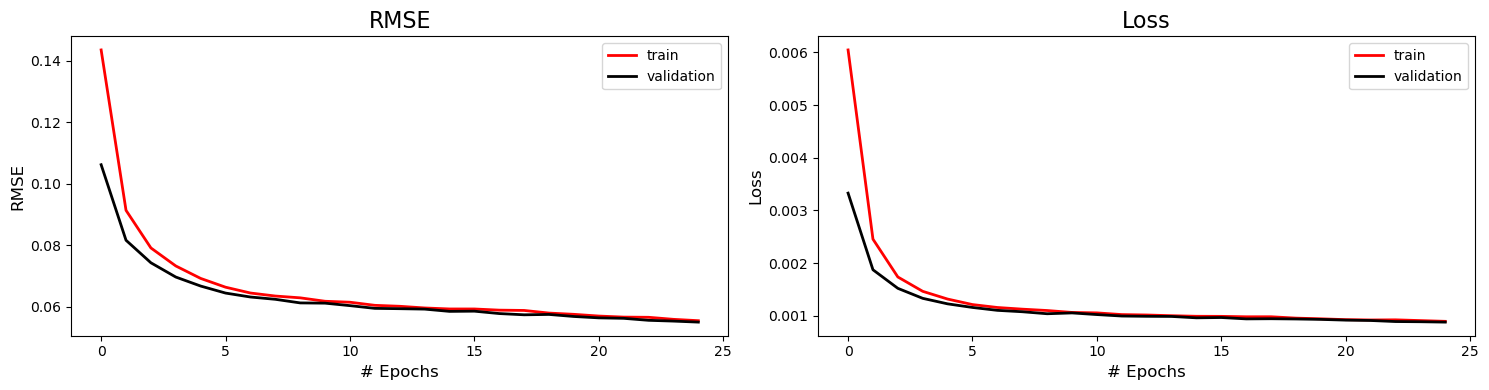

In [17]:
# Plotting training metrics using pre-made function
fig,axs = pu.plot_training_metrics(train_accuracy_history,
                                test_accuracy_history,
                                train_loss_history,
                                test_loss_history
                               )

***

## Step five - Apply trained model

The model is now trained and ready for its denoising capabilities to be tested. 

For the standard network application, the noisy image does not require any data patching nor does it require the active pixel pre-processing required in training. In other words, the noisy image can be fed directly into the network for denoising.

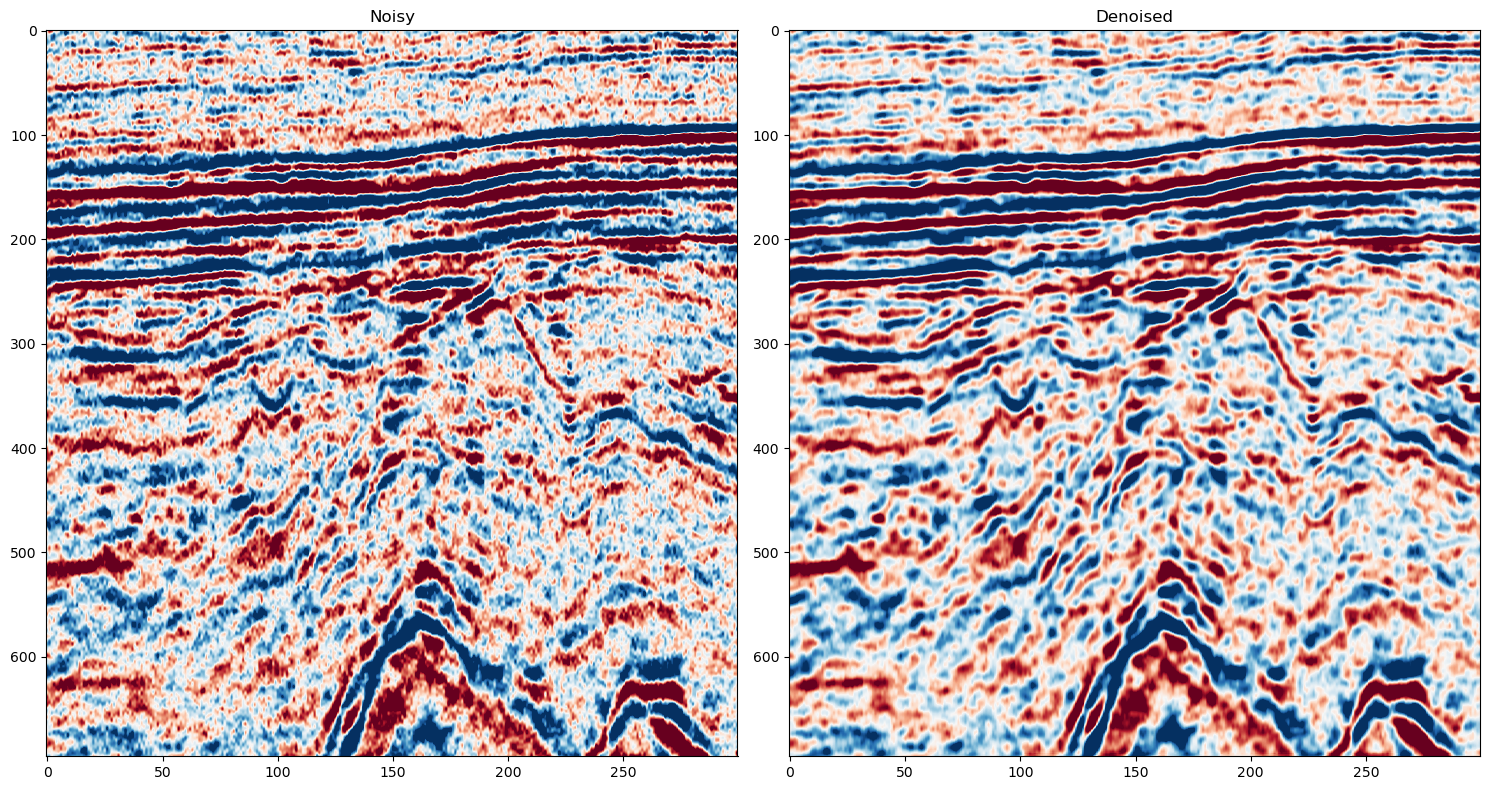

In [18]:
# Convert field dataset to tensor for prediction purposes
torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(field_data,axis=0),axis=0)).float()

# Run test dataset through network
network.eval()
test_prediction = network(torch_testdata.to(device))

# Return to numpy for plotting purposes
test_pred = test_prediction.detach().cpu().numpy().squeeze()

# Use pre-made plotting function to visualise denoising performance
fig,axs = pu.plot_field_results(field_data, test_pred)